In [1]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])

import_or_install('astropy')
import_or_install('astroquery')
import_or_install('gala')

In [2]:
#astropy imports

import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia



In [3]:
# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic


        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


## Scientific background
The Gaia mission is an ESA mission that aims to measure the 3D positions and velocities of a large number of stars throughout the Milky Way. The primary mission objective is to enable studying the formation, structure, and evolutionary history of our Galaxy by measuring astrometry (sky position, parallax, and proper motion) for about 2 billion stars brighter than the Gaia G-band photometric magnitude G ≲ 21. By end of mission (~2022), Gaia will also provide multi-band photometry and low-resolution spectrophotometry for these sources, along with radial or line-of-sight velocities for a subsample of about 100 million stars.

In April 2018, Gaia publicly released its first major catalog of data — data release 2 or DR2 — which provides a subset of these data to anyone with an internet connection. In this tutorial, we will use astrometry, radial velocities, and photometry for a small subset of DR2 to study the kinematics of different types of stars in the Milky Way.

### Using astroquery to retrieve Gaia data
We'll start by querying the Gaia science archive to download astrometric and kinematic data (parallax, proper motion, radial velocity) for a sample of stars near the Sun. We'll use data exclusively from data release 2 [DR2](https://www.cosmos.esa.int/web/gaia/data-release-2) from the Gaia mission. For the demonstration here, let's grab data for a random subset of 4096 stars within a distance of 100 pc from the Sun that have high signal-to-noise astrometric measurements.

To perform the query and to retrieve the data, we'll use the Gaia module in the astroquery package, astroquery.gaia. This module expects us to provide an SQL query to select the data we want (technically it should be an ADQL query, which is similar to SQL but provides some additional functionality for astronomy; to learn more about ADQL syntax and options, [this guide](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook) provides an introduction). We don't need all of the columns that are available in DR2, so we'll limit our query to request the sky position (ra, dec), parallax, proper motion components (pmra, pmdec), radial velocity, and magnitudes (phot_*_mean_mag). More information about the available columns is in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html).

To select stars that have high signal-to-noise parallaxes, we'll use the filter parallax_over_error > 10 to select stars that have small fractional uncertainties. We'll also use the filter radial_velocity IS NOT null to only select stars that have measured radial velocities.

In [5]:
query_text = '''SELECT TOP 16384 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

We now pass this query to the `Gaia.launch_job()` class method to create an anonymous job in the Gaia science archive to run our query. To retrieve the results of this query as an Astropy Table object, we then use the `job.get_results()` method. Note that you may receive a number of warnings (output lines that begin with WARNING:) from the `astropy.io.votable package` — these are expected, and it's OK to ignore these warnings (the `Gaia archive` returns a slightly invalid VOTable).

In [6]:
from pathlib import Path

gaia_data_path = Path("datasets/gaia_data.fits")
if not gaia_data_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)  
    job = Gaia.launch_job(query_text)
    gaia_data = job.get_results()
    gaia_data.write(gaia_data_path)

In [7]:
gaia_data = QTable.read(gaia_data_path)
gaia_data[:10]

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float64,float32,float32,float32
256.8370985186671,46.5081010273448,10.770964834345387,-19.76657104695835,55.92605676622464,-17.673072044811907,12.956912994384766,14.192928314208984,11.859498023986816
129.45826809010867,-6.806694022293258,41.081670013380716,-297.34595349374183,43.83424795415093,35.53814452290586,6.576352119445801,6.931065082550049,6.111272811889648
2.317856723637118,9.00699655780345,17.824765284426462,-171.8278607514459,-1083.8740928197751,-148.91780163518774,13.119074821472168,13.968703269958496,12.223302841186523
330.41287472805976,51.88897801553169,13.0756133009657,-85.30745872006916,-34.23366534215265,-28.726469345049587,12.101919174194336,13.05264949798584,11.149785995483398
147.19500733390703,64.89446697480156,16.93304725892566,2.382528916102615,35.3422776993022,-19.67434662793379,7.0012898445129395,7.242986679077148,6.664536952972412
80.2154121697551,-4.698409026669147,10.952733453482963,94.43034433086909,-51.11033017381004,23.14373705062893,11.307271003723145,11.843748092651367,10.633875846862793
130.85357387757685,-44.02677884321,10.279167265645267,-25.154708979027845,17.61973693017641,40.91502127360303,10.926984786987305,11.411972045898438,10.315131187438965
339.83848696327334,57.35583655498077,11.431122594578381,-88.0760523216923,-46.024711850345625,1.0253186600965876,11.903912544250488,12.650127410888672,11.088520050048828


In [8]:
len(gaia_data)

16384

The data object is now an Astropy Table called `gaia_data` that contains Gaia data for 16384 random stars within 100 pc (or with a parallax > 10 mas) of the Sun, as we requested.

### Using astropy.coordinates to represent and transform stellar positions and velocities
Let's double check that the farthest star is still within 100 pc, as we expect from the parallax selection we did in the query above. To do this, we'll create an Astropy Distance object using the parallax (Note: this inverts the parallax to compute the distance! This is only a good approximation when the parallax signal to noise is large, as we ensured in the query above with parallax_over_error > 10):

In [9]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<Distance 3.49716485 pc>, <Distance 99.99985292 pc>)

It looks like the closest star in our sample is about 3.49 pc away, and the farthest is almost 100 pc, as we expected.

We next want to convert the coordinate position and velocity data from heliocentric, spherical values to Galactocentric, Cartesian values. We'll do this using the (Astropy coordinates)[http://docs.astropy.org/en/latest/coordinates/index.html] transformation machinery. To make use of this functionality, we first have to create a `SkyCoord` object from the Gaia data we downloaded. The Gaia `DR2` data are in the ICRS (equatorial) reference frame, which is also the default frame when creating new `SkyCoord` objects, so we don't need to specify the frame below:

In [10]:
c = coord.SkyCoord(ra=gaia_data['ra'], 
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'], 
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

*Note:* as described in the Gaia `DR2` data model, the Gaia column `pmra` contains the cos(dec) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

Let's again look at the first four coordinates in the SkyCoord object:

In [11]:
c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(256.83709852, 46.50810103, 92.84219338),
     (129.45826809, -6.80669402, 24.3417563 ),
     (  2.31785672,  9.00699656, 56.1017205 ),
     (330.41287473, 51.88897802, 76.47824825)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -19.76657105,    55.92605677,  -17.67307204),
     (-297.34595349,    43.83424795,   35.53814452),
     (-171.82786075, -1083.87409282, -148.91780164),
     ( -85.30745872,   -34.23366534,  -28.72646935)]>

Now that we have a `SkyCoord` object with the Gaia data, we can transform to other coordinate systems. For example, we can transform to the `Galactic` coordinate system (centered on the Sun but with the zero latitude approximately aligned with the Galactic plane) using the `.galactic` attribute (this works for any of the built-in Astropy coordinate frames, e.g., `.fk5` should also work):

In [12]:
c.galactic[:4]

# https://github.com/astropy/astropy/issues/14210
# Need to switch to astropy 5.2 (incompatibility with newer release of numpy)
# Do the following:
# - conda config --add channels conda-forge
# - conda config --set channel_priority strict
# - mamba upgrade --channel=conda-forge astropy
# >> astropy    5.2.1  py310h936d966_0  conda-forge/osx-64      8MB

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [( 72.32926334,  36.8367097 , 92.84219338),
     (232.07542475,  19.9763116 , 24.3417563 ),
     (105.68646983, -52.44715126, 56.1017205 ),
     ( 98.28701089,  -2.66800849, 76.47824825)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  55.13035551,   21.88801174,  -17.67307204),
     (-195.30630898, -228.4545973 ,   35.53814452),
     (-455.13470935, -998.57912013, -148.91780164),
     ( -88.74713695,   23.94268239,  -28.72646935)]>

The Galactic frame is still centered on the solar system `barycenter`, whereas we want to compute the positions and velocities of our sample of stars in a Galactocentric frame, centered on the center of the Milky Way. The `barycenter` is the center of mass of every object in the solar system combined. Our solar system's barycenter constantly changes position. Its position depends on where the planets are in their orbits. The solar system's `barycenter` can range from being near the center of the sun to being outside the surface of the sun.

To do this transformation, Astropy provides the `Galactocentric` frame class, which allows us to use our own conventions for, e.g., the distance from the sun to the Galactic center (`galcen_distance`) or the height of the Sun over the Galactic midplane (`z_sun`). Let's look at the default values for the solar position and velocity:

In [15]:
galcen_coord = coord.Galactocentric()
galcen_coord.galcen_distance, galcen_coord.z_sun

(<Quantity 8.122 kpc>, <Quantity 20.8 pc>)

In [17]:
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=galcen_coord.galcen_distance))
galcen[:4]
                        

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8099.44468803,  70.79989896,  55.66242071),
     (-8136.06090109, -18.04601124,   8.31586669),
     (-8131.24493623,  32.92015736, -44.47693151),
     (-8133.0109288 ,  75.59768012,  -3.55986822)]
 (v_x, v_y, v_z) in km / s
    [(-16.26556759, 233.98501167,   4.89424163),
     (-30.94107553, 226.00094753,  -4.85474972),
     (210.89926667, -11.75804787, -36.02277769),
     ( 48.81632893, 222.24147077,  17.78803683)]>

We can access the positions of the stars using the `.x`, `.y`, and `.z` attributes, for example:

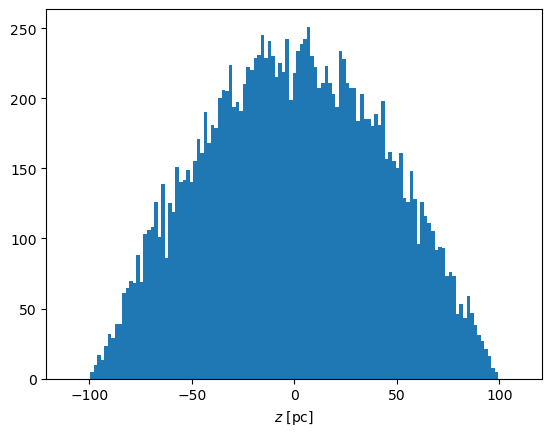

In [21]:
plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 128))
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic `"UV"` plane velocity plot:

Text(0, 0.5, '$v_y$ [$\\mathrm{km\\,s^{-1}}$]')

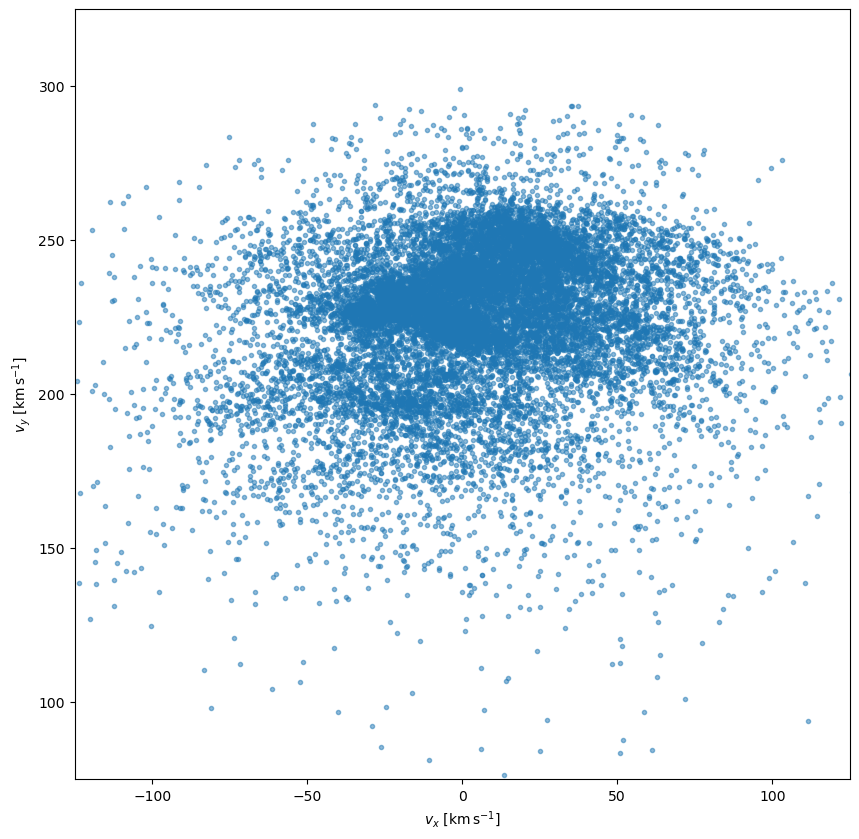

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))

Along with astrometric and radial velocity data, `Gaia` also provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{BP} - G_{RP}$ color and the absolute 
$G$-band magnitude $M_G$.
We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

In [25]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

Text(0, 0.5, '$M_G$')

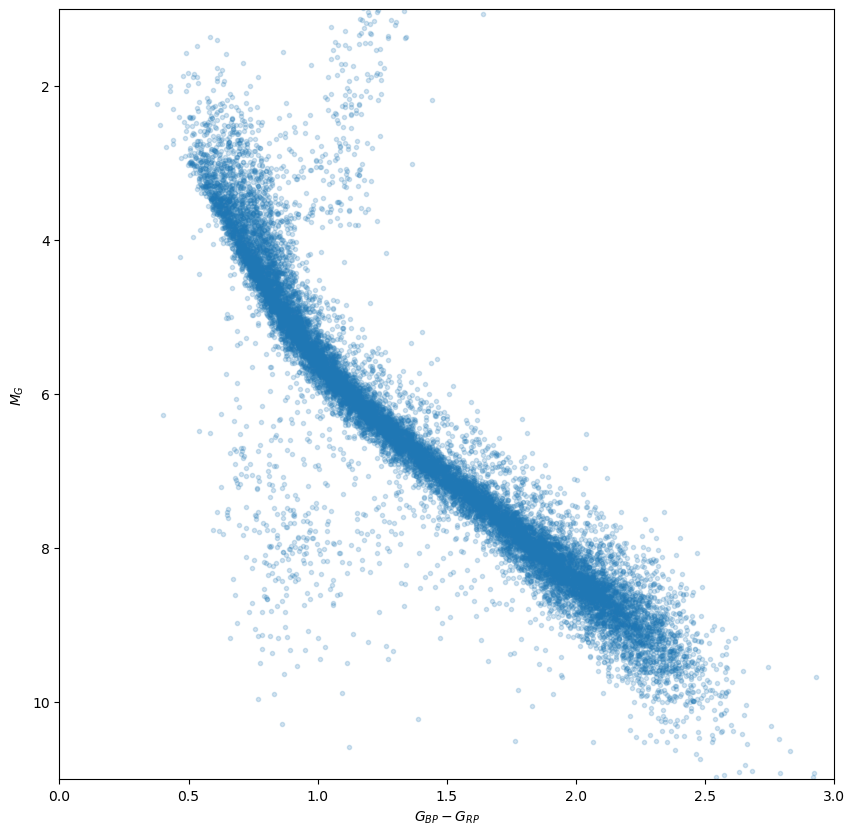

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.2)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In the above, there is a wide range of main sequence star masses which have a range of lifetimes. The most massive stars were likely born in the thin disk and their orbits therefore likely have smaller vertical amplitudes than the typical old main sequence star. To compare, we'll create two sub-selections of the Gaia `CMD` to select massive and low-mass main sequence stars from the `CMD` for comparison. You may see two `RuntimeWarning(s)` from running the next cell — these are expected and it's safe to ignore them.

In [27]:
np.seterr(invalid="ignore")
hi_mass_mask = ((BP_RP > 0.5*u.mag) & (BP_RP < 0.7*u.mag) & 
                (M_G > 2*u.mag) & (M_G < 3.75*u.mag) & 
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

lo_mass_mask = ((BP_RP > 2*u.mag) & (BP_RP < 2.4*u.mag) & 
                (M_G > 8.2*u.mag) & (M_G < 9.7*u.mag) &
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

Let's also define default `colors` to use when visualizing the `high-` and `low-`mass stars:

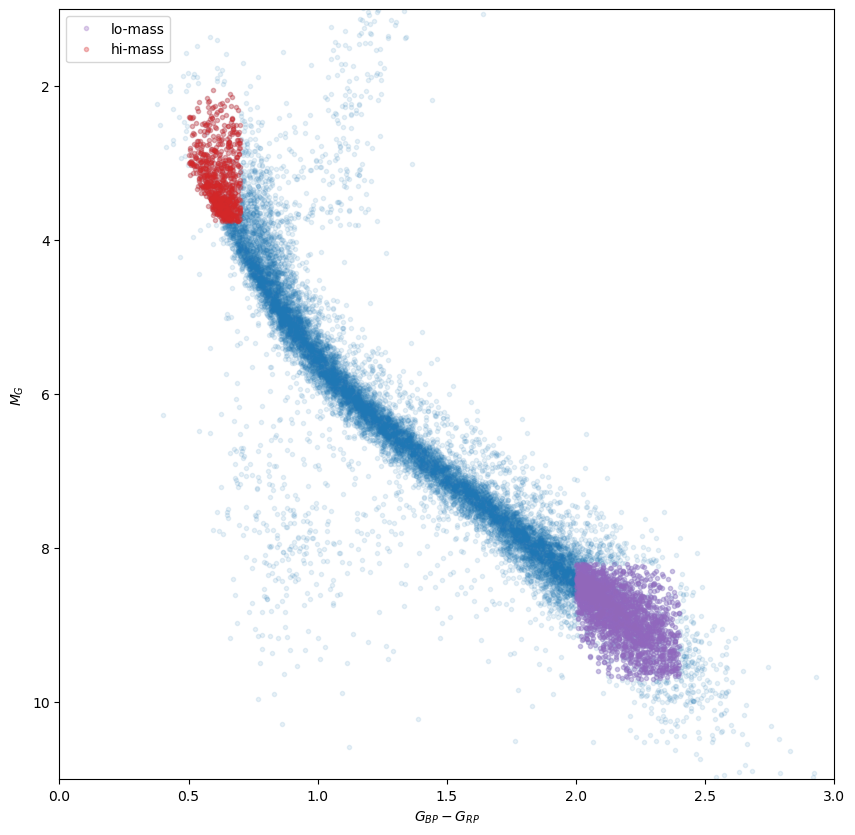

In [34]:
hi_mass_color = 'tab:red'
lo_mass_color = 'tab:purple'

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.1)

for mask, color, label in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color], ['lo-mass', 'hi-mass']):
    ax.plot(BP_RP[mask].value, M_G[mask].value, 
            marker='.', linestyle='none', label=label, 
            alpha=0.3, color=color)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
plt.legend(loc="upper left")
plt.savefig('hilo-100pc.png')

Thus far, we've used the color-magnitude diagram (using parallaxes and photometry from Gaia to compute absolute magnitudes) to select samples of high- and low-mass stars based on their colors.

In what follows, we'll compute Galactic orbits for stars in the high- and low-mass star selections above and compare.

## Using gala to numerically integrate Galactic stellar orbits
Details: [Gala](https://gala.adrian.pw/en/latest/)


`gala` is an `Astropy` affiliated package for Galactic dynamics. gala provides functionality for representing analytic mass models that are commonly used in Galactic dynamics contexts for numerically integrating stellar orbits. For examples, see `Chapter 3 of Binney and Tremaine (2008)`. The gravitational potential models are defined by specifying parameters like `mass`, `scale radii`, or `shape` parameters and can be combined. Once defined, they can be used in combination with numerical integrators provided in `gala` to compute orbits. `gala` comes with a pre-defined, multi-component, but `simple model` for the Milky Way that can be used for orbit integrations. Let's create an instance of the `MilkyWayPotential` model and integrate orbits for the high- and low-mass main sequence stars selected above:

In [35]:
milky_way = gp.MilkyWayPotential()
milky_way

<CompositePotential disk,bulge,nucleus,halo>

In [36]:
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

<CompositePotential disk,bulge,nucleus,halo>

To integrate orbits, we have to combine the mass model with a reference frame into a `Hamiltonian` object. If no reference frame is passed in, it's assumed that we are in a static inertial frame moving with the center of the mass model:



In [37]:
H = gp.Hamiltonian(milky_way)


Now that we have the mass model, we can integrate orbits. Let's now define initial conditions for subsets of the high- and low-mass star selections we did above. Initial conditions in `gala` are specified by creating `PhaseSpacePosition` objects. We can create these objects directly from a `Galactocentric` object, like we have defined above from transforming the Gaia data — we first have to extract the data with a `Cartesian` representation. We can do this by calling `galcen.cartesian`:

In [38]:
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)
w0_hi.shape, w0_lo.shape

((776,), (2249,))

From the above, we can see that we have 776 high-mass star and 2249 low-mass stars in our selections. To integrate orbits, we call the .integrate_orbit() method on the `Hamiltonian` object we defined above, and pass in initial conditions. We also have to specify the timestep for integration, and how long we want to integrate for. We can do this by either specifying the amount of time to integrate for, or by specifying the number of timesteps. Let's specify a timestep of 1 Myr and a time of 500 Myr (approximately two revolutions around the Galaxy for a Sun-like orbit):

In [39]:
orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

With the orbit objects in hand, we can continue our comparison of the orbits of high-mass and low-mass main sequence stars in the solar neighborhood. Let's start by plotting a few orbits. The `.plot()` convenience function provides a quick way to visualize orbits in three Cartesian projections. For example, let's plot the first orbit in each subsample on the same figure:

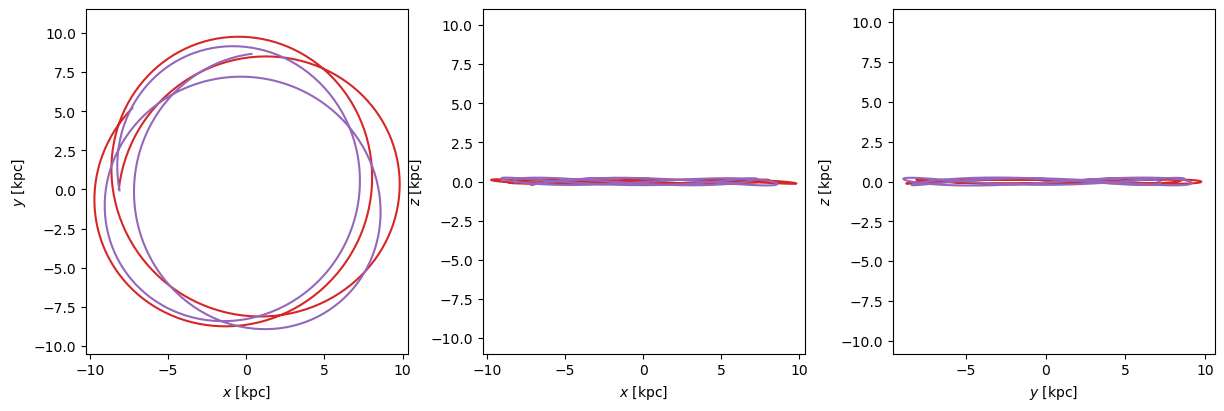

In [40]:
fig = orbits_hi[:, 0].plot(color=hi_mass_color)
_ = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color)

(-0.3, 0.3)

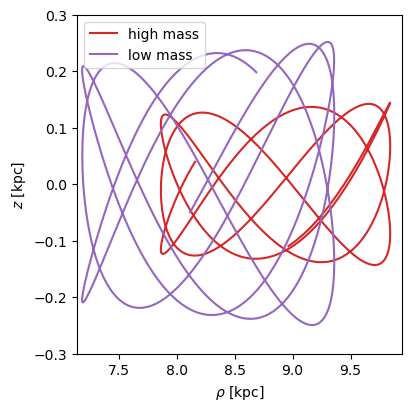

In [41]:
fig = orbits_hi[:, 0].cylindrical.plot(['rho', 'z'], 
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 0].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')
fig.axes[0].set_ylim(-0.3, 0.3)

Already in the above plot we can see that the high-mass star has an orbit with smaller eccentricity (smaller radial variations) and smaller vertical oscillations as compared to the low-mass star. Below, we'll quantify this and look at the vertical excursions of all of the high- and low-mass stars, respectively.

Let's now compare the vertical amplitudes of the orbits in each of our sub-selections! We can compute the (approximate) maximum vertical height of each orbit using the convenience method `.zmax()` (you can see a list of all convenience methods on the Orbit object in the Gala documentation here):

In [42]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

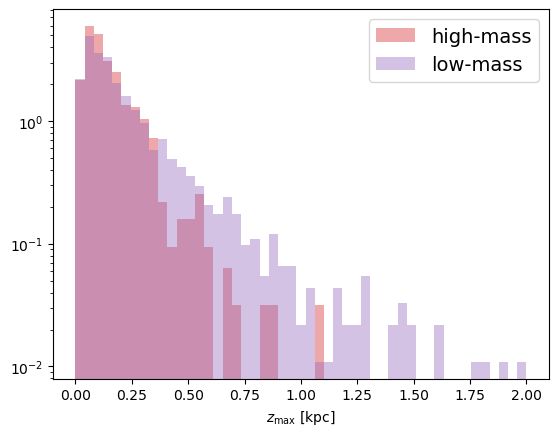

In [43]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

The distribution of `z-heights` for the low-mass (i.e. typically *older*) stars is more extended, as we predicted!

In this tutorial, we've used astroquery to query the Gaia science archive to retrieve kinematic and photometric data for a small sample of stars with well-measured parallaxes from `Gaia DR2`. We used the colors and absolute magnitudes of these stars to select subsamples of high- and low-mass stars, which, on average, will provide us with subsamples of stars that are younger and older, respectively. We then constructed a model for the gravitational field of the Milky Way and numerically integrated the orbits of all stars in each of the two subsamples. Finally, we used the orbits to compute the maximum height that each star reaches above the Galactic midplane and showed that the younger (higher-mass) stars tend to have smaller excursions from the Galactic plane, consistent with the idea that stars are either born in a "thinner" disk and dynamically "heated," or that older stars formed with a larger vertical scale-height.